# Assignment RL: Text Flappy Bird

In [1]:
#! pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

DEPRECATION: Loading egg at /Users/mayajanvier/anaconda3/envs/env_dents/lib/python3.11/site-packages/pycryptodomex-3.19.0-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/mayajanvier/anaconda3/envs/env_dents/lib/python3.11/site-packages/blobfile-2.1.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/mayajanvier/anaconda3/envs/env_dents/lib/python3.11/site-packages/tqdm-4.66.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading 

In [62]:
# import dependencies 
import os, sys
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from plot_utils import *

## 1. Monte-Carlo Control agent

In [272]:
def generate_episode_from_Q(env, Q, epsilon, nA, max_score=2000):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0] 
    rewards = 0
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environment 
        next_state, reward, done, _, info  = env.step(action)  
        episode.append((state, action, reward))
        state = next_state
        rewards += reward 
        if done:
            break
        if rewards >= max_score:
          #print(score)
          break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s) 
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [273]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05,max_score=2000):
    nA = env.action_space.n
    rewards = []
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA, max_score) 
        rewards.append(sum([ep[2] for ep in episode]))
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma) 
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards

In [117]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
policy, Q, Rewards = mc_control(env, 100000, alpha=0.02)

Episode 100000/100000.

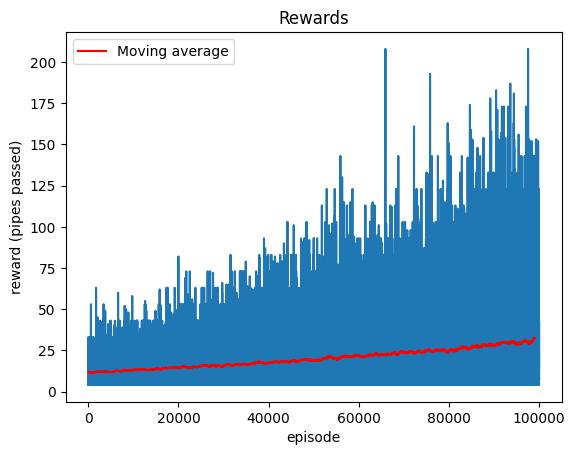

In [118]:
plt.plot(Rewards)
plt.plot(np.convolve(Rewards, np.ones(1000)/1000, mode='valid'), label='Moving average', color='r')
plt.title("Rewards")
plt.legend()
plt.xlabel("episode")
plt.ylabel('reward (pipes passed)')
plt.show()

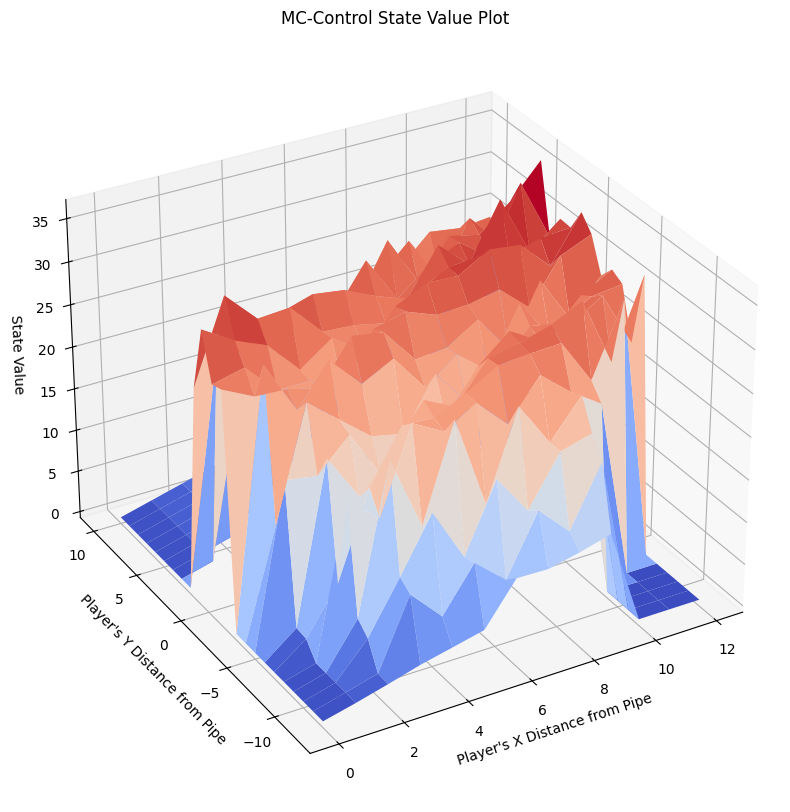

In [119]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_flappy_values(V, 'MC-Control')

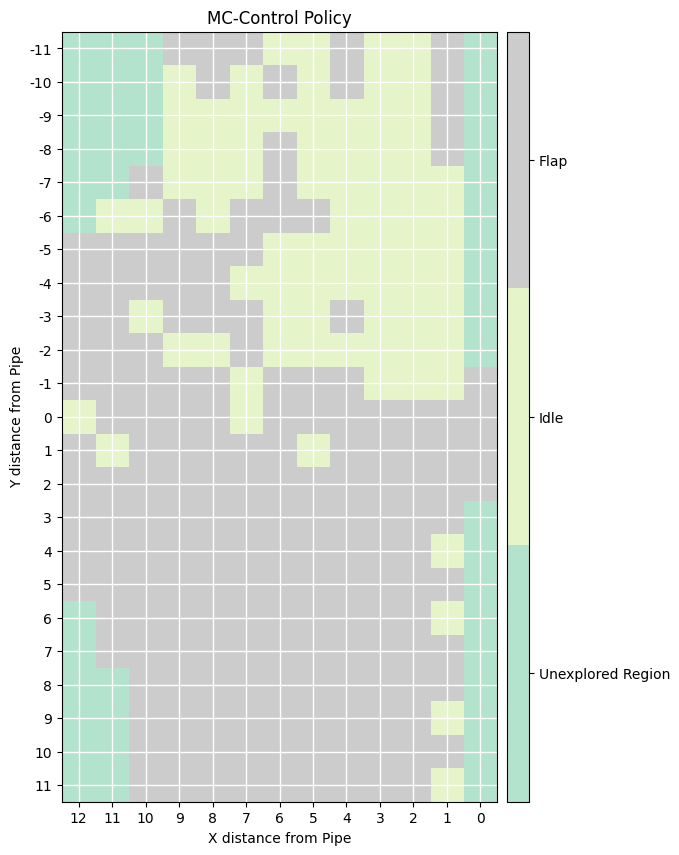

In [120]:
plot_policy_flappy(policy, "MC-Control")

### Hyperparameter tuning 

In [274]:
params = {"alpha": [0.2, 0.4, 0.8,1], "eps_start": [0.1, 0.5, 0.99]}
MC_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
for alpha in params['alpha']:
    for eps_start in params['eps_start']:
        i+=1
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        obs = env.reset()
        _, Q, rew = mc_control(env,num_episodes = 10000, 
                                eps_start = eps_start,
                                max_score=1500,
                                eps_decay = 0.999, eps_min = 1e-4, 
                                alpha=alpha, 
                                gamma = 0.95)
        MC_rewards[alpha,eps_start] = rew
        env.close()
        print(f'Trial {i}/{total_trials}')

Episode 10000/10000.Trial 1/9
Episode 10000/10000.Trial 2/9
Episode 10000/10000.Trial 3/9
Episode 10000/10000.Trial 4/9
Episode 10000/10000.Trial 5/9
Episode 10000/10000.Trial 6/9
Episode 10000/10000.Trial 7/9
Episode 10000/10000.Trial 8/9
Episode 10000/10000.Trial 9/9


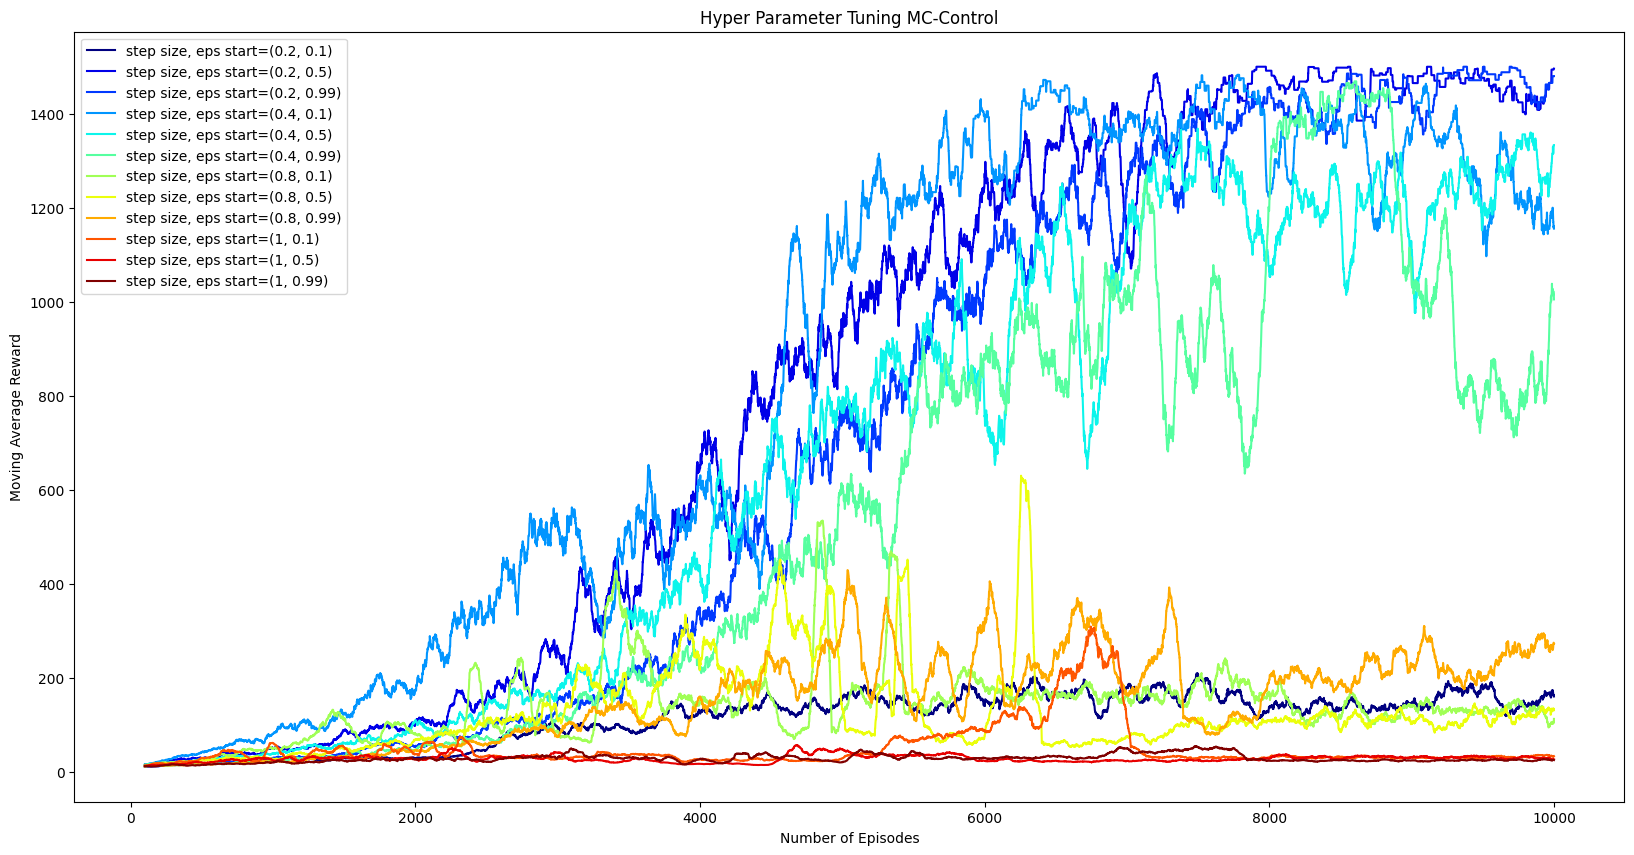

In [288]:
plot_flappy_HP_tuning(MC_rewards,'step size, eps start','MC-Control')

## 2. Sarsa($\lambda$)

In [303]:
from tqdm import tqdm 

def initialize_sarsa_lambda_agent(num_states, num_actions, epsilon_start, eps_decay, eps_min, step_size, discount, lambd, seed):
    """
    Initialize the SARSA(λ) agent.
    """
    state_dict = {}
    q = np.zeros((num_states, num_actions))
    eligibility_trace = np.zeros((num_states, num_actions))
    rand_generator = np.random.RandomState(seed)
    return state_dict, q, eligibility_trace, epsilon_start, eps_decay, eps_min, step_size, discount, lambd, rand_generator

def epsilon_greedy_action(q_values, epsilon, num_actions, rand_generator):
    """
    Epsilon-greedy action selection.
    """
    if rand_generator.rand() < epsilon:
        return rand_generator.randint(num_actions)
    else:
        return argmax(q_values, rand_generator)

def argmax(q_values, rand_generator):
    """
    Selects the action with the highest value using argmax with random tie-breaking.
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return rand_generator.choice(ties)

def sarsa_lambda_agent_start(state, state_dict, q, epsilon, num_actions, rand_generator, eps_decay, eps_min):
    """
    Start of the agent 
    """
    epsilon = max(epsilon * eps_decay, eps_min) 
    
    if state not in state_dict.keys():
        state_dict[state] = len(state_dict)
    state_idx = state_dict[state]
    
    q_s = q[state_idx, :]
    action = epsilon_greedy_action(q_s, epsilon, num_actions, rand_generator)
    
    return action, state_idx

def sarsa_lambda_agent_step(reward, state, state_dict, q, eligibility_trace, epsilon, num_actions, step_size, discount, lambd, previous_state_idx, previous_action, rand_generator):
    """
    Single step 
    """
    if state not in state_dict.keys():
        state_dict[state] = len(state_dict)
    state_idx = state_dict[state]

    q_s = q[state_idx,:]
    action = epsilon_greedy_action(q_s, epsilon, num_actions, rand_generator)

    expected_q = 0
    q_max = np.max(q_s) 

    epsilon_prob = np.ones(num_actions) * epsilon / num_actions
    greedy_prob = (q_s == q_max) * (1 - epsilon) / np.sum(q_s == q_max)
    pi = epsilon_prob + greedy_prob
    expected_q = np.sum(pi * q_s)

    delta = reward + discount * expected_q - q[previous_state_idx, previous_action]
    eligibility_trace[previous_state_idx, previous_action] += 1
    
    q += step_size * delta * eligibility_trace
    eligibility_trace *= discount * lambd
    
    return action, state_idx

def sarsa_lambda_agent_end(reward, state_dict, q, eligibility_trace, step_size, previous_state_idx, previous_action):
    """
    Executes when the agent reaches the terminal state.
    """
    delta = reward - q[previous_state_idx, previous_action]
    eligibility_trace[previous_state_idx, previous_action] += 1
    
    q += step_size * delta * eligibility_trace


In [352]:
def train_sarsa_lambda_agent(env, num_episodes, agent_params, max_score=1000):
    """
    Train a SARSA(λ) agent on the given environment.
    """
    # Initialize the SARSA(λ) agent
    state_dict, q, eligibility_trace, epsilon, eps_decay, eps_min, step_size, discount, lambd, rand_generator = initialize_sarsa_lambda_agent(**agent_params)
    
    rewards = []
    for episode in tqdm(range(num_episodes)):
        state,_ = env.reset()
        action, previous_state_idx = sarsa_lambda_agent_start(state, state_dict, q, epsilon, env.action_space.n, rand_generator, eps_decay, eps_min)
        episode_reward = 0
        score = 0
        
        while True:
            next_state, reward, done, _, info = env.step(action)
            episode_reward += reward
            score += info['score']

            
            
            if done:
                sarsa_lambda_agent_end(reward, state_dict, q, eligibility_trace, step_size, previous_state_idx, action)
                break
            
            action, current_state_idx = sarsa_lambda_agent_step(reward, next_state, state_dict, q, eligibility_trace, epsilon, env.action_space.n, step_size, discount, lambd, previous_state_idx, action, rand_generator)
            previous_state_idx = current_state_idx
            
            if episode_reward >= max_score:
                break


        rewards.append(episode_reward)
        
    return state_dict, q, rewards


observation_space = (14, (22, -11))
eps_decay = 0.99999
eps_min =1e-4
num_states = observation_space[0] * (observation_space[1][0] - observation_space[1][1] + 1)

agent_params = {
    "num_states": num_states,
    "num_actions": env.action_space.n,
    "epsilon_start": 0.1,
    "eps_decay": eps_decay,
    "eps_min": eps_min,
    "step_size": 0.1,
    "discount": 0.99,
    "lambd": 0.9,
    "seed": 0
}

states_sarsa, trained_q_values, rewards = train_sarsa_lambda_agent(env, 1000, agent_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 368.90it/s]


In [353]:
def build_Q_table(env, states, q_values):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, key in states.items():
        Q[state] = q_values[key]
    return Q


Q_Sarsa = build_Q_table(env, states_sarsa, trained_q_values)

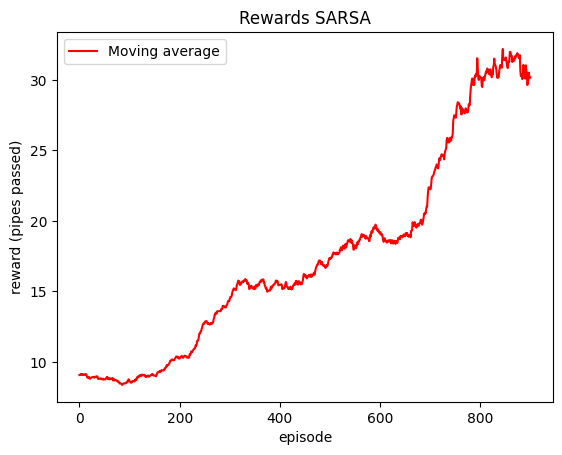

In [354]:
#plt.plot(S_sarsa)
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), label='Moving average', color='r')
plt.title("Rewards SARSA")
plt.legend()
plt.xlabel("episode")
plt.ylabel('reward (pipes passed)')
plt.show()

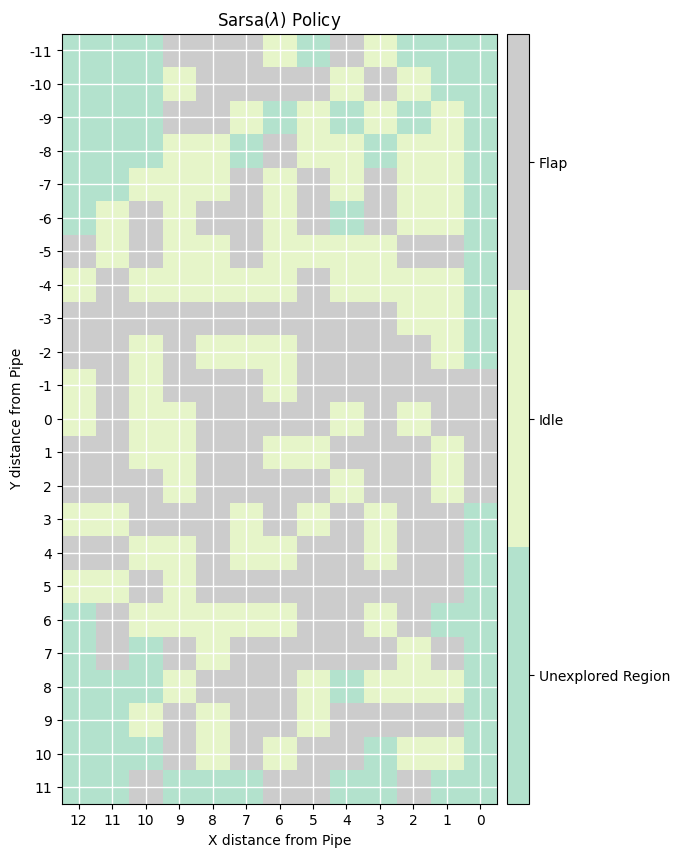

In [359]:
policy_S = dict((k,np.argmax(v)) for k, v in Q_Sarsa.items())
plot_policy_flappy(policy_S,"Sarsa($\lambda$)")

<>:2: DeprecationWarning: invalid escape sequence '\l'


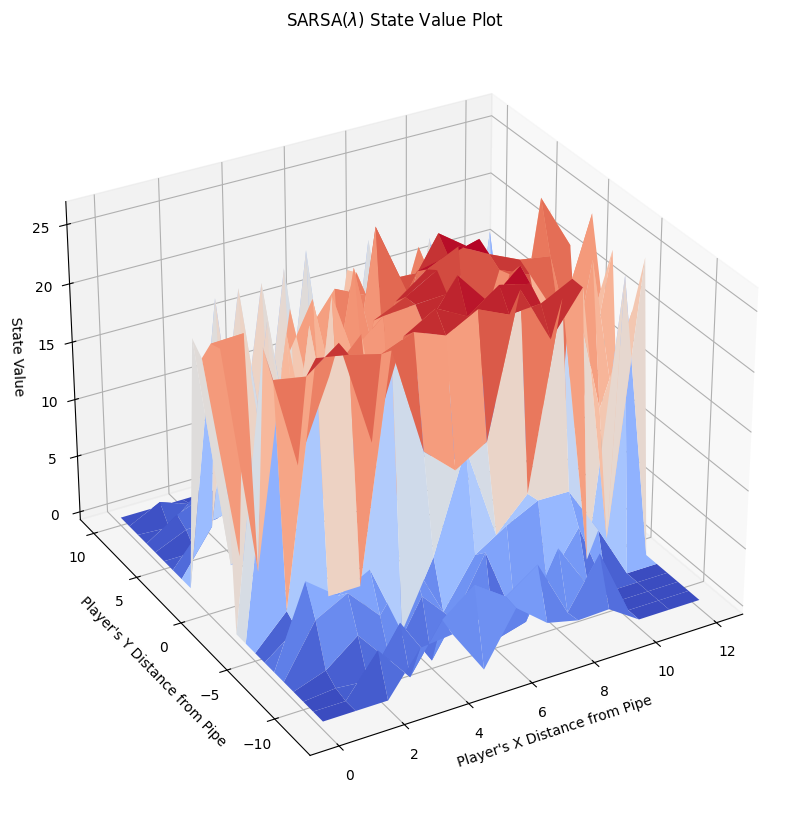

In [360]:
V_sarsa = dict((k,np.max(v)) for k, v in Q_Sarsa.items())
plot_flappy_values(V_sarsa,'SARSA($\lambda$)')

### Hyperparameters tuning

In [284]:
params = {"epsilon": [0.05, 0.1, 0.99], "step_size": [0.1, 0.4, 0.8, 1]}
S_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
#for discount in params['discount']:
for epsilon in params['epsilon']:
    for step_size in params['step_size']:
        i+=1
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        obs = env.reset()
        agent_params = {
                    "num_states": num_states,
                    "num_actions": env.action_space.n,
                    "epsilon_start": epsilon,
                    "eps_decay": 0.99,
                    "eps_min": 0.01,
                    "step_size": step_size,
                    "discount": 0.99,
                    "lambd": 0.5,
                    "seed": 1234
}
        _,Q, rew = train_sarsa_lambda_agent(env, num_episodes=10000, agent_params=agent_params, max_score=1500)
        S_rewards[epsilon, step_size] = rew
        env.close()
        print(f'Trial {i}/{total_trials}')

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:16<00:00, 130.12it/s]


Trial 1/12


100%|██████████| 10000/10000 [03:00<00:00, 55.27it/s]


Trial 2/12


100%|██████████| 10000/10000 [02:03<00:00, 80.99it/s]


Trial 3/12


100%|██████████| 10000/10000 [01:30<00:00, 110.52it/s]


Trial 4/12


100%|██████████| 10000/10000 [01:10<00:00, 142.07it/s]


Trial 5/12


100%|██████████| 10000/10000 [01:17<00:00, 128.49it/s]


Trial 6/12


100%|██████████| 10000/10000 [01:03<00:00, 158.48it/s]


Trial 7/12


100%|██████████| 10000/10000 [00:52<00:00, 190.30it/s]


Trial 8/12


100%|██████████| 10000/10000 [00:07<00:00, 1336.85it/s]


Trial 9/12


100%|██████████| 10000/10000 [00:08<00:00, 1207.97it/s]


Trial 10/12


100%|██████████| 10000/10000 [00:07<00:00, 1301.60it/s]


Trial 11/12


100%|██████████| 10000/10000 [00:07<00:00, 1309.08it/s]

Trial 12/12


<>:1: DeprecationWarning: invalid escape sequence '\l'


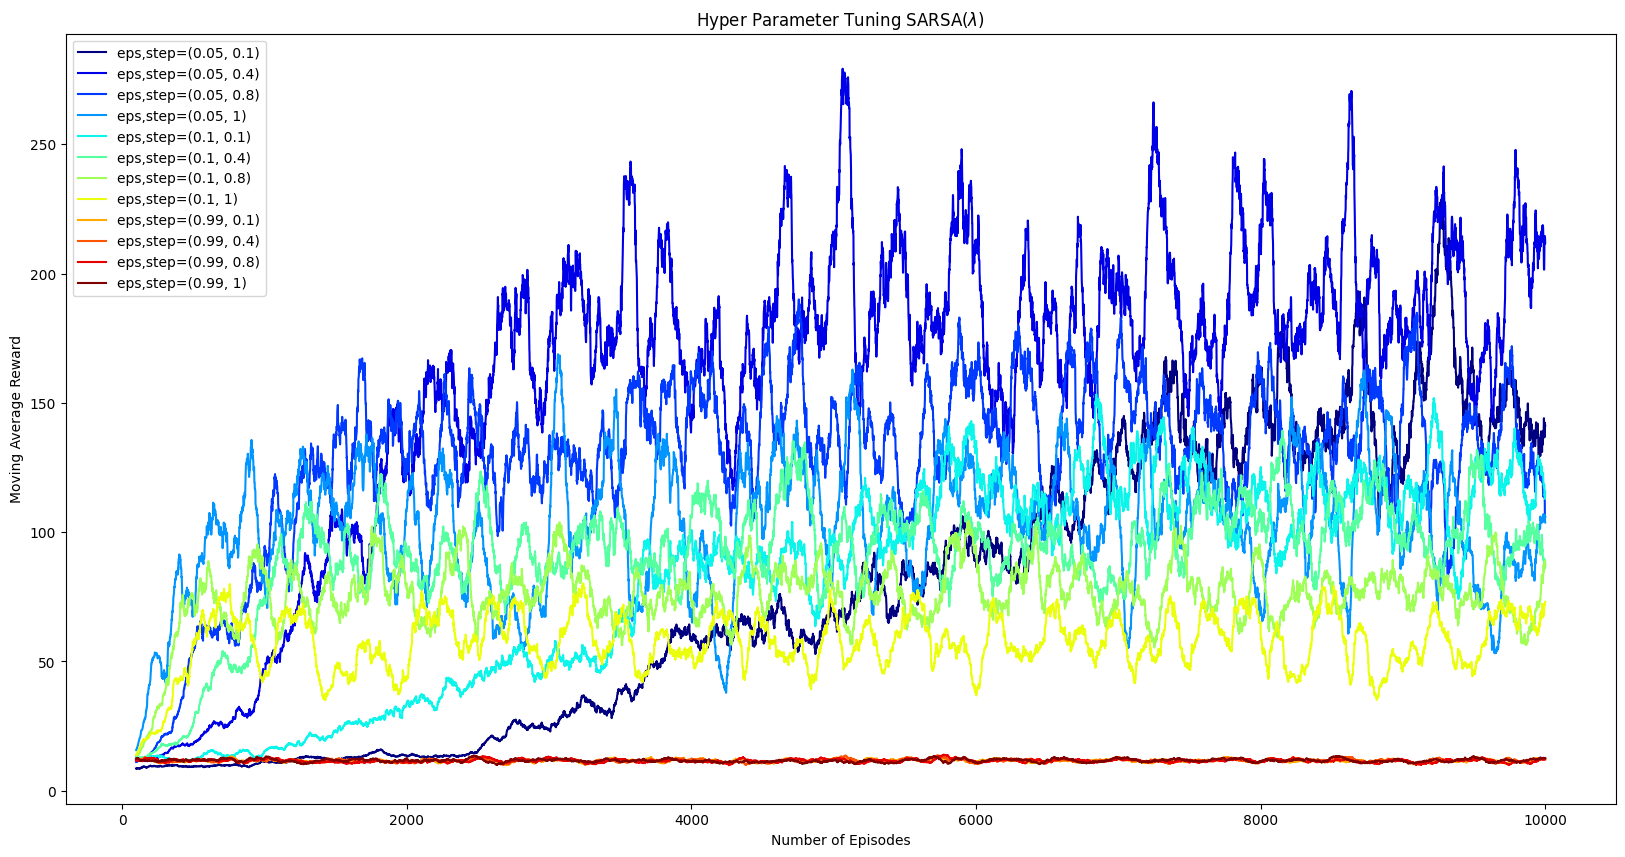

In [285]:
plot_flappy_HP_tuning(S_rewards,'eps,step',"SARSA($\lambda$)")

## 3. Try agents on new environments

### MC Control

In [324]:
env_train = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
policyMC_best, QMC_best, RMC_best =  mc_control(env_train, 10000, alpha=0.2, eps_start=0.99, eps_decay = 0.999, eps_min = 1e-4, gamma = 0.95)

Episode 10000/10000.

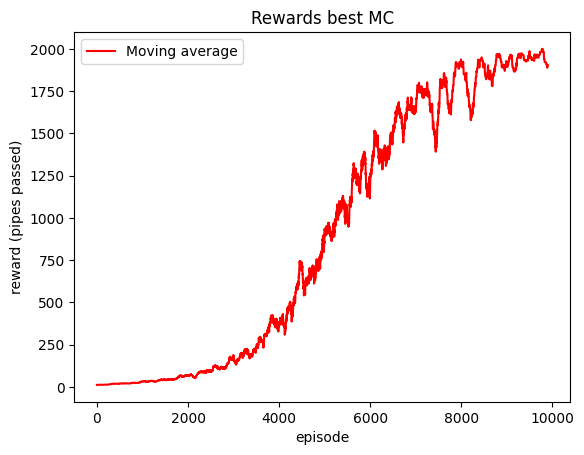

In [325]:
plt.plot(np.convolve(RMC_best, np.ones(100)/100, mode='valid'), label='Moving average', color='r')
plt.title("Rewards best MC")
plt.legend()
plt.xlabel("episode")
plt.ylabel('reward (pipes passed)')
plt.show()

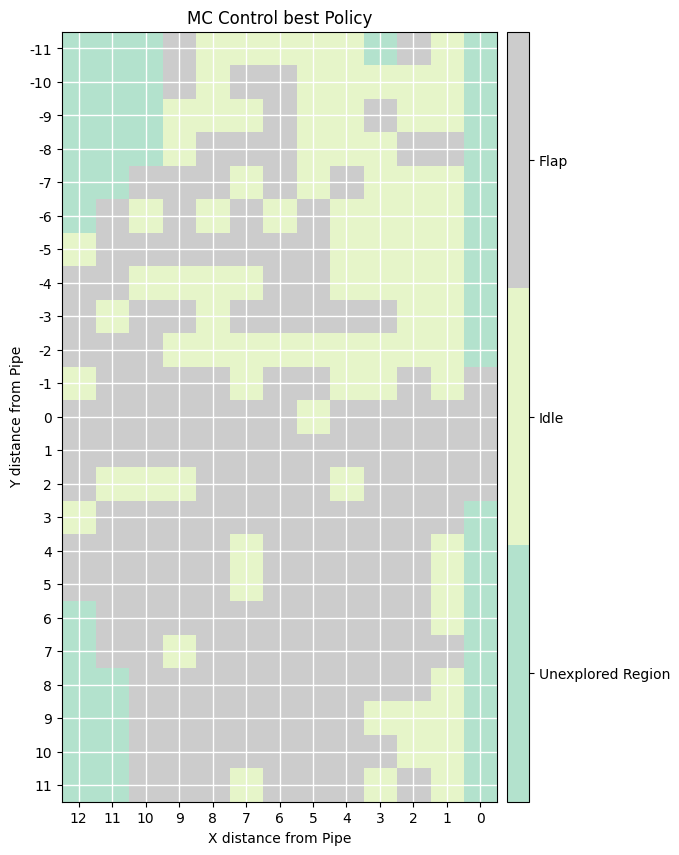

In [326]:
plot_policy_flappy(policyMC_best,"MC Control best")

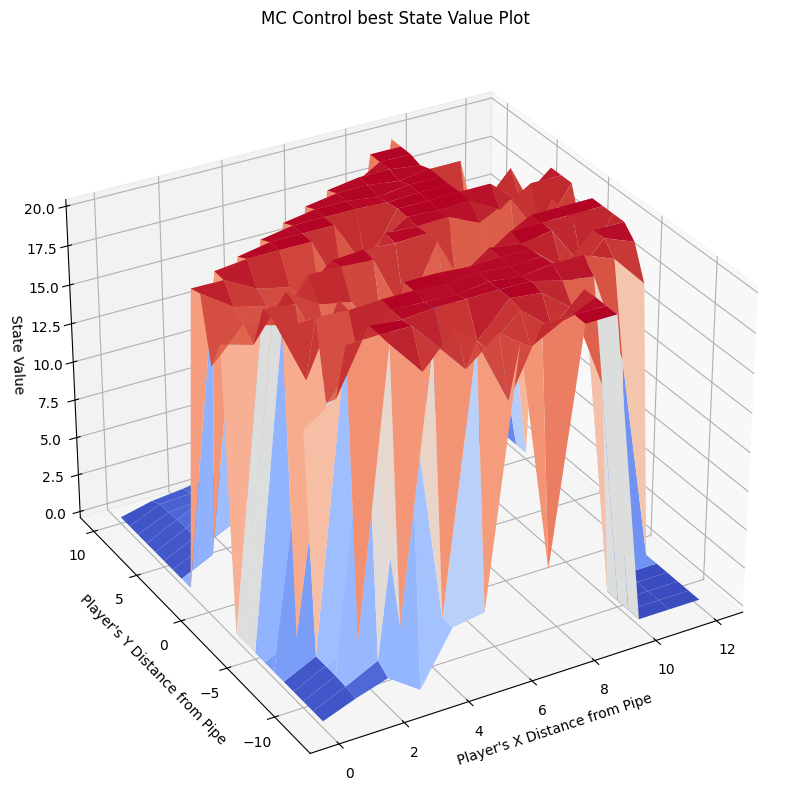

In [327]:
V_MC_best = dict((k,np.max(v)) for k, v in QMC_best.items())
plot_flappy_values(V_MC_best,"MC Control best")

In [385]:
def play_mc_control(env, policy, max_steps=10000):
    """
    Play the Monte Carlo control policy in the given environment.
    """
    state, _ = env.reset()
    total_reward = 0
    steps = 0

    while steps < max_steps:
        if state not in policy:
            # If the state is unseen during training, choose a random action
            action = env.action_space.sample()
        else:
            action = policy[state]

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = next_state
        steps += 1

        if done:
            break
    
    env.close()

    return total_reward


In [413]:
env_test = gym.make('TextFlappyBird-v0', height = 10, width = 10, pipe_gap =6)
rew_list_MC = []
for k in range(1000):
    play_reward_mc = play_mc_control(env_test,policyMC_best) 
    rew_list_MC.append(play_reward_mc)

np.mean(rew_list_MC)

10000.0

In [414]:
print(np.min(rew_list_MC))
print(np.max(rew_list_MC))

10000
10000


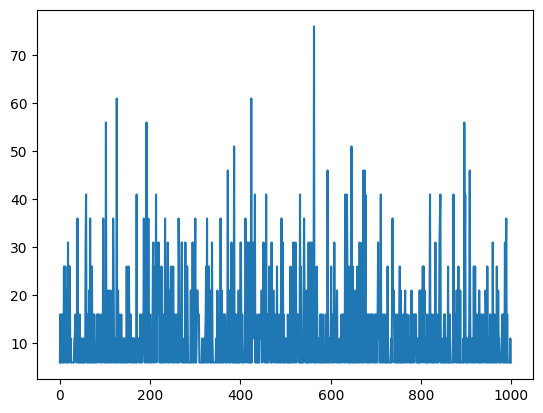

In [396]:
plt.plot(rew_list_MC)

It can play much longer ! 

### SARSA($\lambda$)

In [398]:
def play_sarsa_agent(env, state_dict, q, epsilon, num_actions, rand_generator):
    """
    Play the SARSA(λ) agent in the given environment using the learned policy.
    """
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        if state not in state_dict:
            # If the state is unseen during training, choose a random action
            action = rand_generator.randint(num_actions)
        else:
            state_idx = state_dict[state]
            q_values = q[state_idx, :]
            action = epsilon_greedy_action(q_values, epsilon, num_actions, rand_generator)

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        state = next_state

    return total_reward


In [366]:
env_train = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent_params = {
                    "num_states": num_states,
                    "num_actions": env.action_space.n,
                    "epsilon_start": 0.05,
                    "eps_decay": 0.99,
                    "eps_min": 0.01,
                    "step_size": 0.4,
                    "discount": 0.99,
                    "lambd": 0.5,
                    "seed": 1234
}
stateS_best, QS_values_best, RS_best =  train_sarsa_lambda_agent(env_train, 10000, agent_params=agent_params,max_score=2000)

  0%|          | 46/10000 [00:00<00:21, 453.82it/s]

100%|██████████| 10000/10000 [02:38<00:00, 62.98it/s]


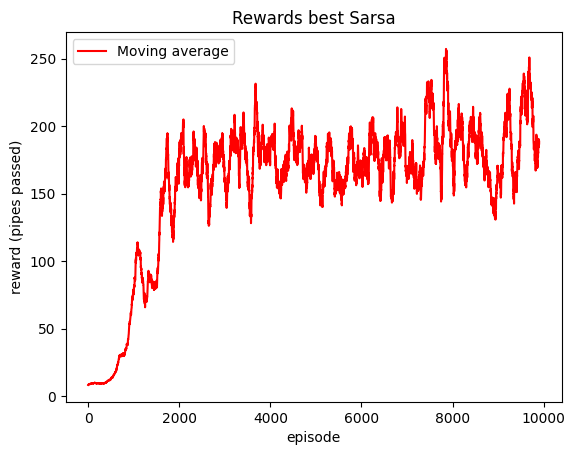

In [367]:
plt.plot(np.convolve(RS_best, np.ones(100)/100, mode='valid'), label='Moving average', color='r')
plt.title("Rewards best Sarsa")
plt.legend()
plt.xlabel("episode")
plt.ylabel('reward (pipes passed)')
plt.show()

<>:4: DeprecationWarning: invalid escape sequence '\l'


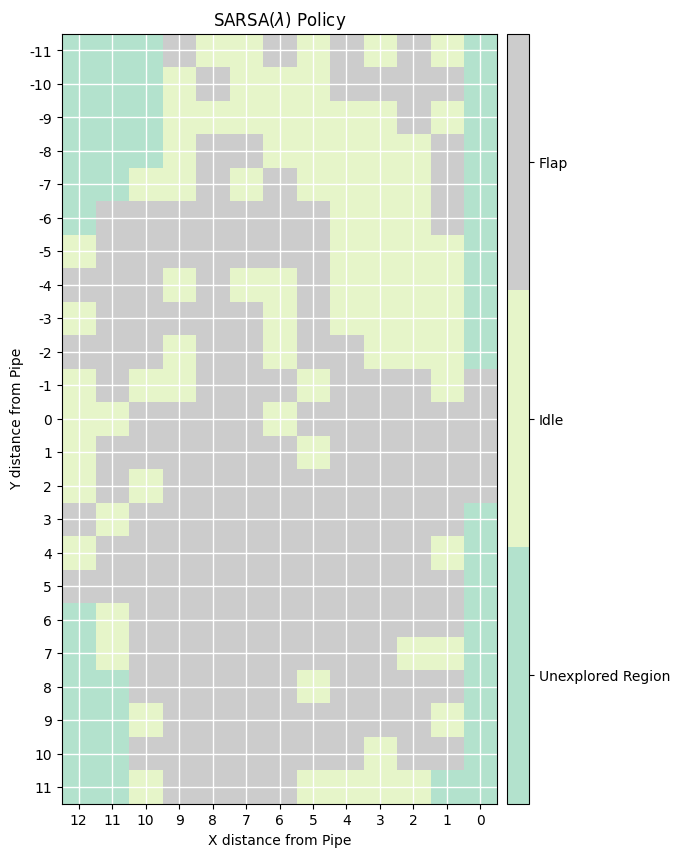

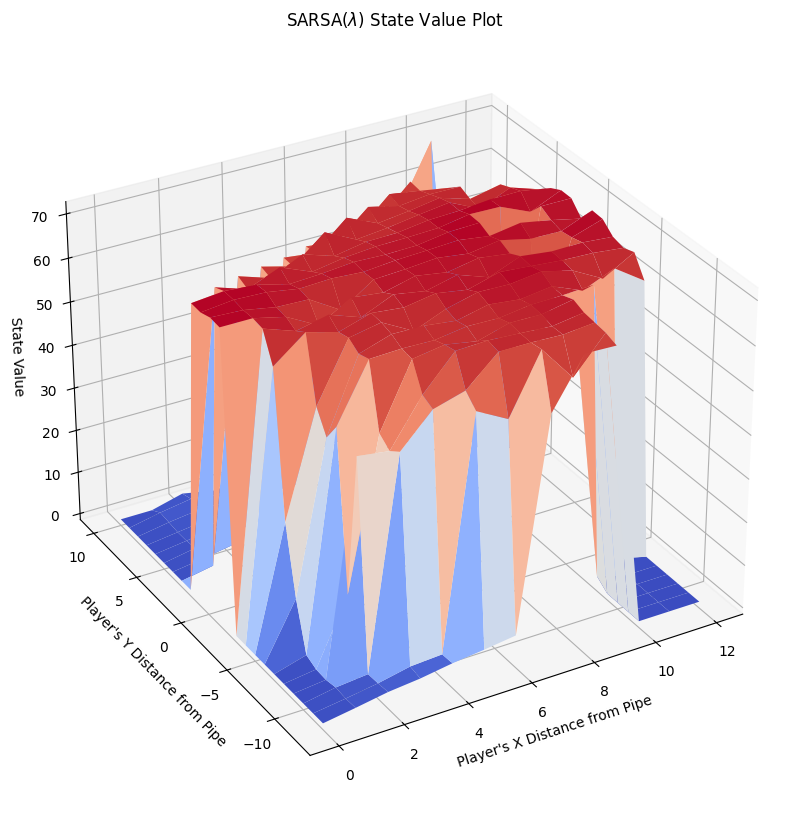

In [368]:
QSbest = build_Q_table(env_train,stateS_best,QS_values_best)
policyS_best = dict((k,np.argmax(v)) for k, v in QSbest.items())
VS_best = dict((k,np.max(v)) for k, v in QSbest.items())
plot_policy_flappy(policyS_best,"SARSA($\lambda$)")
plot_flappy_values(VS_best, "SARSA($\lambda$)")


In [421]:
rand_generator = np.random.RandomState(1234)
env_test = gym.make('TextFlappyBird-v0', height = 10, width = 10, pipe_gap =6)
rew_list_S= []
for k in range(1000):
    play_reward_S = play_sarsa_agent(env_test, stateS_best, QS_values_best, epsilon=0.05, num_actions=env_test.action_space.n, rand_generator=rand_generator)
    rew_list_S.append(play_reward_S)

np.mean(rew_list_S)

194.775

In [422]:
print(np.min(rew_list_S))
print(np.max(rew_list_S))

3
1160


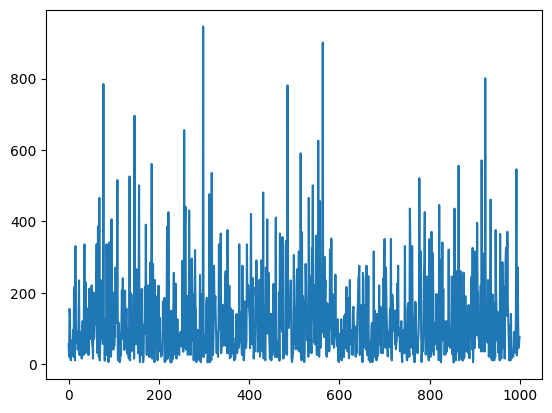

In [402]:
plt.plot(rew_list_S)